# Poisson problem

Let us solve the Poisson problem of finding $u$ satisfying 

$$
\begin{aligned}
-\Delta u + u& = f && \text { in  } (0,10)^2,
\\
\frac{\partial u }{\partial n } & = 0 
&& \text{ on the boundary parts}.
\end{aligned}
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from time import time

In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle((0,0),(10,10),bcs=['bottom','right','top','left'])

In [3]:
ref_sol= exp(-2*((x-4)**2+(y-6)**2))
refdx=ref_sol.Diff(x)
refdy=ref_sol.Diff(y)
rhs = -refdx.Diff(x)-refdy.Diff(y)+ref_sol
ref_sol_grad = CoefficientFunction( (refdx,refdy) )

In [4]:
def Solve(order=1, maxh=1):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    
    fes = H1(mesh, order=order)
    sol = GridFunction(fes)
    
    u,v = fes.TnT()

    a = BilinearForm (fes, symmetric=True)
    a += (grad(u)*grad(v)+u*v)*dx
    
    f = LinearForm(fes)
    f +=rhs*v*dx

    with TaskManager():
        f.Assemble()
        a.Assemble()
        t1 = time()
        sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky") * f.vec
        t2 = time()-t1
    H1err=sqrt( Integrate((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol)),mesh,VOL,2*order) )

    return (fes.ndof, t2, H1err)

<IPython.core.display.Javascript object>


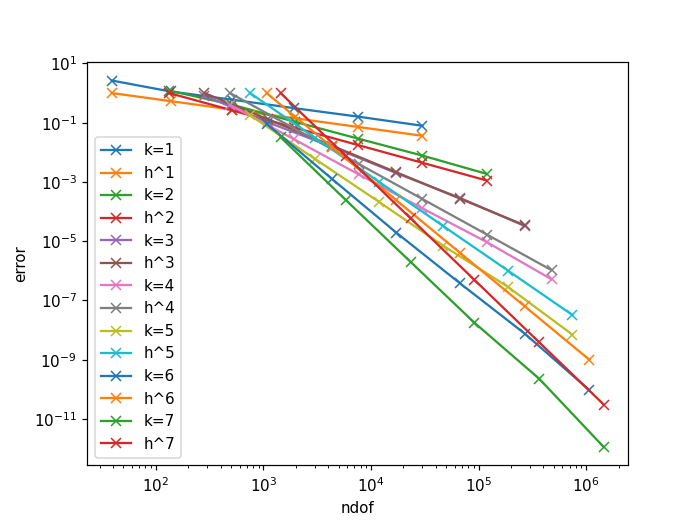

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import interactive

result = []
orders = [1,2,3,4,5,6,7]
maxhs  = [2,1,0.5,0.25,0.125,0.0625]

for k in orders:
    result.append([])
    for maxh in maxhs:
        result[-1].append(Solve(order=k, maxh=maxh))
        
ndofs = True

plt.figure(1)
for i in range(len(orders)):
    ndof,t,err = zip(*result[i])
    #plt.plot(t, err, '-x', label="k="+str(orders[i]))
    if ndofs:
        plt.plot(ndof, err, '-x', label="k="+str(orders[i]))
        plt.plot(ndof, [1/(sqrt(n)**orders[i])*sqrt(ndof[0]**orders[i]) for n in ndof], '-x', label="h^"+str(orders[i]))
    else:
        plt.plot(maxhs, err, '-x', label="k="+str(orders[i]))
        plt.plot(maxhs, [h**orders[i]/(5**i) for h in maxhs], '-x', label="h^"+str(orders[i]))

plt.yscale('log')
plt.xscale('log')
if ndofs:
    plt.xlabel("ndof")
else:
    plt.xlabel("h")
#plt.xlabel("time")
plt.ylabel("error")
plt.legend()
plt.show()
interactive(True)

<IPython.core.display.Javascript object>


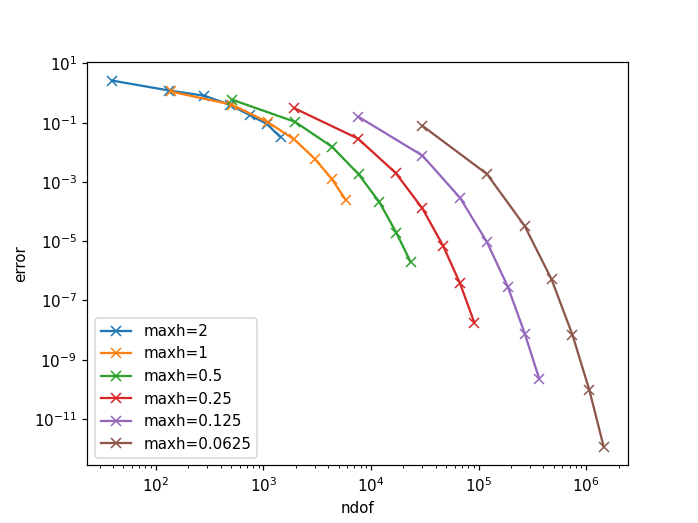

In [8]:
result = []
for maxh in maxhs:
    result.append([])
    for k in orders:
        result[-1].append(Solve(order=k, maxh=maxh))

plt.figure(2)
for i in range(len(maxhs)):
    ndof,t,err = zip(*result[i])
    plt.plot(ndof, err, '-x', label="maxh="+str(maxhs[i]))
    #plt.plot(t, err, '-x', label="maxh="+str(maxhs[i]))

plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
#plt.xlabel("time")
plt.ylabel("error")
plt.legend()
plt.show()
interactive(True)